# NHIS Data Processing and Analysis Pipeline
This notebook processes National Health Interview Survey (NHIS) data to analyze health metrics across different industries and demographics, with a focus on COVID-19.

**Key Variables**

See link for variable descriptions: https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NHIS/2023/adult-summary.pdf


| Variable         | Description                                        |
|-----------------|----------------------------------------------------|
| SRVY_YR         | Year of the National Health Interview Survey       |
| EVERCOVD_A      | Ever had COVID-19                                  |
| SHTCVD191_A     | COVID-19 vaccination                                |
| EMPDYSMSS3_A    | Days missed work, past 12 months (top-coded)      |
| HICOV_A         | Have health insurance                             |
| EMDINDSTN1_A    | Detailed 2-digit recode for sample adult's industry |
| SEX_A           | Sex of Sample Adult                               |
| AGEP_A          | Age of SA (top coded)                            |
| EDUCP_A         | Educational level of sample adult                |
| REGION          | Household region                                 |

# SECTION 1: AWS and SageMaker Setup

In [23]:
import boto3
import sagemaker
import pandas as pd
import io
from pyathena import connect
import sys
import warnings
warnings.filterwarnings('ignore')

# EDA Tools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Initialize SageMaker session and AWS environment
sess = sagemaker.Session()
bucket = "usd-team1-ads508"
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sm = boto3.client("sagemaker", region_name=region)

In [3]:
# Initialize S3 resources at the beginning to avoid reference errors
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')

In [4]:
# Define S3 paths for data storage
s3_public_path = "s3://usd-team1-ads508/ld_data/"
s3_private_path = f"s3://{bucket}/ld_data"
s3_processed_path = f"s3://{bucket}/ld_data_processed"

In [5]:
# Store paths for later use
%store s3_public_path
%store s3_private_path
%store s3_processed_path

Stored 's3_public_path' (str)
Stored 's3_private_path' (str)
Stored 's3_processed_path' (str)


In [6]:
# Copy CSV files from public to private bucket
!aws s3 cp --recursive {s3_public_path} {s3_private_path}/ --include "*.csv" > /dev/null 2>&1


# SECTION 2: Data Processing Functions

In [7]:
# Standardize Column Names
def standardize_column_names(df, year):
    """
    Standardize column names across different years of NHIS data.
    
    Args:
        df: DataFrame containing NHIS data
        year: Year of the survey (integer)
        
    Returns:
        DataFrame with standardized column names
    """
    # Create a copy to avoid modifying the original
    df_standardized = df.copy()
    
    # COVID-19 diagnosis variable standardization
    if year in [2020, 2021, 2022]:
        if 'CVDDIAG_A' in df.columns:
            df_standardized['EVERCOVD_A'] = df['CVDDIAG_A']
    elif year not in [2023]:  # In 2019, COVID didn't exist
        df_standardized['EVERCOVD_A'] = None  # Add column with nulls for 2019
    
    # COVID-19 vaccination standardization
    if year == 2021:
        if 'SHTCVD19_A' in df.columns:
            df_standardized['SHTCVD191_A'] = df['SHTCVD19_A']
    elif year not in [2022, 2023]:  # In 2019-2020, no COVID vaccination
        df_standardized['SHTCVD191_A'] = None  # Add column with nulls
    
    # Work days missed standardization
    if year in [2019, 2020]:
        if 'EMPDYSMSS2_A' in df.columns:
            df_standardized['EMPDYSMSS3_A'] = df['EMPDYSMSS2_A']
    
    # Industry code standardization
    if year == 2020:
        if 'EMDINDSTR1_A' in df.columns:
            df_standardized['EMDINDSTN1_A'] = df['EMDINDSTR1_A']
    elif year not in [2021, 2023]:  # Handle years where this var doesn't exist
        df_standardized['EMDINDSTN1_A'] = None
    
    # Education standardization
    if year in [2019, 2020]:
        if 'EDUC_A' in df.columns:
            df_standardized['EDUCP_A'] = df['EDUC_A']
    
    # Region - check if it exists for the later years
    if 'REGION' not in df.columns and year in [2021, 2022, 2023]:
        df_standardized['REGION'] = None
    
    # Select only the columns we need, handling missing columns
    columns_to_select = ['SRVY_YR', 'EVERCOVD_A', 'SHTCVD191_A', 'EMPDYSMSS3_A', 
                         'HICOV_A', 'EMDINDSTN1_A', 'SEX_A', 'AGEP_A', 'EDUCP_A', 'REGION']
    
    # Create a list of columns that exist in the dataframe
    existing_columns = [col for col in columns_to_select if col in df_standardized.columns]
    
    # Return only columns that exist
    return df_standardized[existing_columns]

In [8]:
# Extract year from filename
def extract_year_from_filename(filename):
    """
    Extract the year from a filename if present.
    
    Args:
        filename: String containing the filename
        
    Returns:
        Integer year if found, None otherwise
    """
    for y in ['2019', '2020', '2021', '2022', '2023']:
        if y in filename:
            return int(y)
    return None

In [9]:
# Process CSV files
def process_csv_file(bucket_name, file_key, processed_prefix):
    """
    Process a CSV file from S3, standardize columns, and save back to S3.
    
    Args:
        bucket_name: S3 bucket name
        file_key: Key of the file to process
        processed_prefix: Destination prefix for processed files
        
    Returns:
        Boolean indicating success or failure
    """
    try:
        # Skip already processed files
        if processed_prefix in file_key:
            return False
            
        # Get the file content
        obj = s3.Object(bucket_name, file_key).get()
        df = pd.read_csv(io.BytesIO(obj['Body'].read()))
        
        # Try to extract year from filename or from SRVY_YR column
        year = None
        if 'SRVY_YR' in df.columns:
            year = int(df['SRVY_YR'].iloc[0])
        else:
            # Try to extract from filename
            filename = file_key.split('/')[-1]
            year = extract_year_from_filename(filename)
            if year:
                df['SRVY_YR'] = year
        
        if year is None:
            print(f"Warning: Could not determine year for {file_key}, skipping")
            return False
        
        print(f"Processing {file_key} (Year: {year})")
        
        # Standardize column names
        processed_df = standardize_column_names(df, year)
        
        # Ensure all required columns exist (fill with NULL if missing)
        required_columns = ['SRVY_YR', 'EVERCOVD_A', 'SHTCVD191_A', 'EMPDYSMSS3_A', 
                           'HICOV_A', 'EMDINDSTN1_A', 'SEX_A', 'AGEP_A', 'EDUCP_A', 'REGION']
        
        for col in required_columns:
            if col not in processed_df.columns:
                processed_df[col] = None
        
        # Reorder columns to match the Athena table schema
        processed_df = processed_df[required_columns]
        
        # Save processed file
        filename = file_key.split('/')[-1]
        processed_key = f"{processed_prefix}/{filename}"
        
        csv_buffer = io.StringIO()
        processed_df.to_csv(csv_buffer, index=False)
        s3_client.put_object(Bucket=bucket_name, 
                           Key=processed_key, 
                           Body=csv_buffer.getvalue())
        
        print(f"Saved processed file to {processed_key}")
        return True
    except Exception as e:
        print(f"Error processing {file_key}: {e}")
        return False

# SECTION 3: Process All CSV Files

In [10]:
# List files in the bucket and process each one
print("Processing CSV files...")
processed_prefix = "ld_data_processed"

Processing CSV files...


In [11]:
# Only process files from the source directory, not the processed directory
response = s3_client.list_objects_v2(Bucket=bucket, Prefix="ld_data/")  # Add trailing slash to avoid processed files

if 'Contents' in response:
    success_count = 0
    for obj in response['Contents']:
        if obj['Key'].endswith('.csv'):
            if process_csv_file(bucket, obj['Key'], processed_prefix):
                success_count += 1
    
    print(f"Successfully processed {success_count} files")
else:
    print("No files found in the source location")

Processing ld_data/adult19.csv (Year: 2019)
Saved processed file to ld_data_processed/adult19.csv
Processing ld_data/adult20.csv (Year: 2020)
Saved processed file to ld_data_processed/adult20.csv
Processing ld_data/adult21.csv (Year: 2021)
Saved processed file to ld_data_processed/adult21.csv
Processing ld_data/adult22.csv (Year: 2022)
Saved processed file to ld_data_processed/adult22.csv
Processing ld_data/adult23.csv (Year: 2023)
Saved processed file to ld_data_processed/adult23.csv
Successfully processed 5 files


# SECTION 4: Create Athena Database

In [12]:
database_name = "db_508"
s3_staging_dir = f"s3://{bucket}/athena/staging"

In [13]:
# Connect to Athena
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [14]:
# Create database
create_db_statement = f"CREATE DATABASE IF NOT EXISTS {database_name}"
print(create_db_statement)
pd.read_sql(create_db_statement, conn)

CREATE DATABASE IF NOT EXISTS db_508


""


In [15]:
# Verify database creation
show_db_statement = "SHOW DATABASES"
df_show = pd.read_sql(show_db_statement, conn)
print(df_show.head(5))

  database_name
0        db_508
1       default


In [16]:
# Mark database creation as successful if database exists
ingest_create_athena_db_passed = database_name in df_show['database_name'].values
print(f"Database creation successful: {ingest_create_athena_db_passed}")
%store ingest_create_athena_db_passed

Database creation successful: True
Stored 'ingest_create_athena_db_passed' (bool)


# SECTION 5: Create Main NHIS Data Table

In [17]:
if not ingest_create_athena_db_passed:
    print("[ERROR] You need to create the Athena database first")
else:
    # Define table
    table_name = "nhis_dataset"
    
    # Drop table if it exists to recreate it
    drop_table_statement = f"DROP TABLE IF EXISTS {database_name}.{table_name}"
    pd.read_sql(drop_table_statement, conn)
    
    # Statement to execute with actual path to processed data
    create_table_statement = f"""CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
        SRVY_YR int,
        EVERCOVD_A int,
        SHTCVD191_A int,
        EMPDYSMSS3_A int,
        HICOV_A int,
        EMDINDSTN1_A int,
        SEX_A int,
        AGEP_A int,
        EDUCP_A int,
        REGION int
    ) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' 
    LOCATION '{s3_processed_path}'
    TBLPROPERTIES ('skip.header.line.count'='1')"""
    
    # Print statement with redacted sensitive information
    print_statement = create_table_statement.replace(s3_processed_path, "s3://[REDACTED_BUCKET]/[REDACTED_PATH]")
    print(print_statement)
    
    # Execute statement
    pd.read_sql(create_table_statement, conn)
    
    # Verify table creation
    show_tables_statement = f"SHOW TABLES in {database_name}"
    df_show = pd.read_sql(show_tables_statement, conn)
    print(df_show.head(5))
    
    # Mark table creation as successful if table exists
    ingest_create_athena_table_passed = table_name in df_show['tab_name'].values
    print(f"Table creation successful: {ingest_create_athena_table_passed}")
    %store ingest_create_athena_table_passed

CREATE EXTERNAL TABLE IF NOT EXISTS db_508.nhis_dataset(
        SRVY_YR int,
        EVERCOVD_A int,
        SHTCVD191_A int,
        EMPDYSMSS3_A int,
        HICOV_A int,
        EMDINDSTN1_A int,
        SEX_A int,
        AGEP_A int,
        EDUCP_A int,
        REGION int
    ) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n' 
    LOCATION 's3://[REDACTED_BUCKET]/[REDACTED_PATH]'
    TBLPROPERTIES ('skip.header.line.count'='1')
                      tab_name
0       county_health_rankings
1        industry_code_mapping
2            industry_year_avg
3                 nhis_dataset
4  nhis_dataset_with_estimates
Table creation successful: True
Stored 'ingest_create_athena_table_passed' (bool)


# SECTION 6: Validate NHIS Data Table

In [18]:
# Query to count total records in the table
count_query = f"""
SELECT COUNT(*) as total_records 
FROM {database_name}.{table_name}
"""
print("Query to count total records:")
print(count_query)

Query to count total records:

SELECT COUNT(*) as total_records 
FROM db_508.nhis_dataset



In [19]:
# Execute the query
df_count = pd.read_sql(count_query, conn)
# Display the result
print(f"Total records in {table_name}: {df_count['total_records'].iloc[0]}")

Total records in nhis_dataset: 150220


In [20]:
# Query to select the first 10 rows from the table
sample_query = f"""
SELECT *
FROM {database_name}.{table_name}
LIMIT 10
"""
print("Query to retrieve sample records:")
print(sample_query)

# Execute the query
df_sample = pd.read_sql(sample_query, conn)
# Display the result
print(f"\nSample records from {table_name}:")
display(df_sample)

Query to retrieve sample records:

SELECT *
FROM db_508.nhis_dataset
LIMIT 10


Sample records from nhis_dataset:


,srvy_yr,evercovd_a,shtcvd191_a,empdysmss3_a,hicov_a,emdindstn1_a,sex_a,agep_a,educp_a,region
0,2020,2.0,None,NaN,1,NaN,1,85,5,3
1,2020,2.0,None,1.0,1,78.0,1,39,5,3
2,2020,2.0,None,0.0,1,78.0,1,42,4,3
3,2020,NaN,None,0.0,1,64.0,1,32,8,3
4,2020,NaN,None,NaN,1,NaN,2,85,4,3
5,2020,NaN,None,NaN,1,NaN,2,70,8,3
6,2020,NaN,None,0.0,1,68.0,2,32,8,3
7,2020,2.0,None,NaN,1,NaN,2,77,4,3
8,2020,2.0,None,NaN,1,NaN,1,71,6,3
9,2020,2.0,None,NaN,1,NaN,2,69,6,3


In [34]:
# 5.2 Basic Statistics
basic_stats_query = f"""
SELECT 
    AVG(AGEP_A) as avg_age,
    MIN(AGEP_A) as min_age,
    MAX(AGEP_A) as max_age,
    AVG(EMPDYSMSS3_A) as avg_days_missed,
    SUM(CASE WHEN HICOV_A = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*) as percent_insured
FROM {database_name}.{table_name}
"""

try:
    df_basic_stats = pd.read_sql(basic_stats_query, conn)
    print("Basic Statistics:")
    display(df_basic_stats)
except Exception as e:
    print(f"An error occurred: {e}")
    print("Query attempted:")
    print(basic_stats_query)

Basic Statistics:


,avg_age,min_age,max_age,avg_days_missed,percent_insured
0,52.928585,18,99,14.34373,93.303155


In [21]:
# 5.3 Distribution of Categorical Variables

# List of categorical variables
cat_vars = ['SEX_A', 'EVERCOVD_A', 'SHTCVD191_A', 'HICOV_A', 'EMDINDSTN1_A', 'EDUCP_A', 'REGION']

# Function to get distribution for a categorical variable
def get_distribution(var):
    query = f"""
    SELECT 
        {var}, 
        COUNT(*) as count,
        COUNT(*) * 100.0 / SUM(COUNT(*)) OVER() as percentage
    FROM {database_name}.{table_name}
    WHERE {var} IS NOT NULL
    GROUP BY {var}
    ORDER BY {var}
    """
    return pd.read_sql(query, conn)

In [27]:
# Get distribution for each categorical variable
for var in cat_vars:
    df_dist = get_distribution(var)
    print(f"\nDistribution of {var}:")
    display(df_dist)

    # Print value counts for variables with many categories
    if df_dist[var].nunique() > 10:
        print(f"\nTop 10 most common values for {var}:")
        display(df_dist.head(10))


Distribution of SEX_A:


,SEX_A,count,percentage
0,1,68687,45.724271
1,2,81517,54.265078
2,7,10,0.006657
3,9,6,0.003994



Distribution of EVERCOVD_A:


,EVERCOVD_A,count,percentage
0,1,27289,26.147154
1,2,76307,73.114107
2,7,128,0.122644
3,8,451,0.432129
4,9,192,0.183966



Distribution of SHTCVD191_A:


,SHTCVD191_A,count,percentage
0,1,61998,78.348561
1,2,15554,19.656013
2,7,381,0.481480
3,8,1135,1.434330
4,9,63,0.079615



Distribution of HICOV_A:


,HICOV_A,count,percentage
0,1,140160,93.303155
1,2,9853,6.559047
2,7,101,0.067235
3,9,106,0.070563



Distribution of EMDINDSTN1_A:


,EMDINDSTN1_A,count,percentage
0,1,395,0.712521
1,2,229,0.413082
2,3,52,0.093800
3,4,19,0.034273
4,5,64,0.115446
...,...,...,...
77,78,3111,5.611776
78,79,37,0.066742
79,97,774,1.396179
80,98,186,0.335516



Top 10 most common values for EMDINDSTN1_A:


,EMDINDSTN1_A,count,percentage
0,1,395,0.712521
1,2,229,0.413082
2,3,52,0.093800
3,4,19,0.034273
4,5,64,0.115446
5,6,39,0.070350
6,7,61,0.110035
7,8,129,0.232697
8,9,480,0.865848
9,10,3637,6.560600



Distribution of EDUCP_A:


,EDUCP_A,count,percentage
0,0,152,0.101185
1,1,10351,6.890561
2,2,2340,1.557715
3,3,3412,2.271335
4,4,34023,22.648782
5,5,23091,15.371455
6,6,5830,3.880975
7,7,13603,9.055385
8,8,34425,22.916389
9,9,16548,11.015843



Top 10 most common values for EDUCP_A:


,EDUCP_A,count,percentage
0,0,152,0.101185
1,1,10351,6.890561
2,2,2340,1.557715
3,3,3412,2.271335
4,4,34023,22.648782
5,5,23091,15.371455
6,6,5830,3.880975
7,7,13603,9.055385
8,8,34425,22.916389
9,9,16548,11.015843



Distribution of REGION:


,REGION,count,percentage
0,1,25024,16.658235
1,2,33108,22.039675
2,3,54440,36.240181
3,4,37648,25.061909


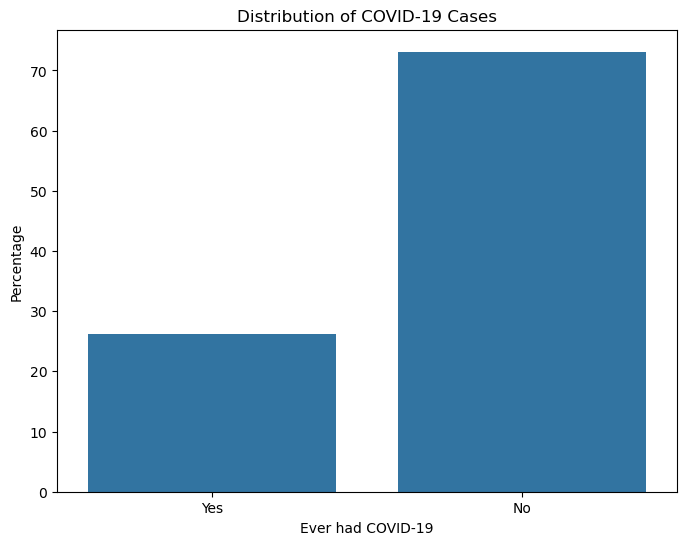

In [28]:
# EVERCOVD_A: Ever had COVID-19
covid_dist = get_distribution('EVERCOVD_A')
covid_dist['EVERCOVD_A'] = covid_dist['EVERCOVD_A'].map({1: 'Yes', 2: 'No'})
plt.figure(figsize=(8, 6))
sns.barplot(x='EVERCOVD_A', y='percentage', data=covid_dist)
plt.title('Distribution of COVID-19 Cases')
plt.xlabel('Ever had COVID-19')
plt.ylabel('Percentage')
plt.show()

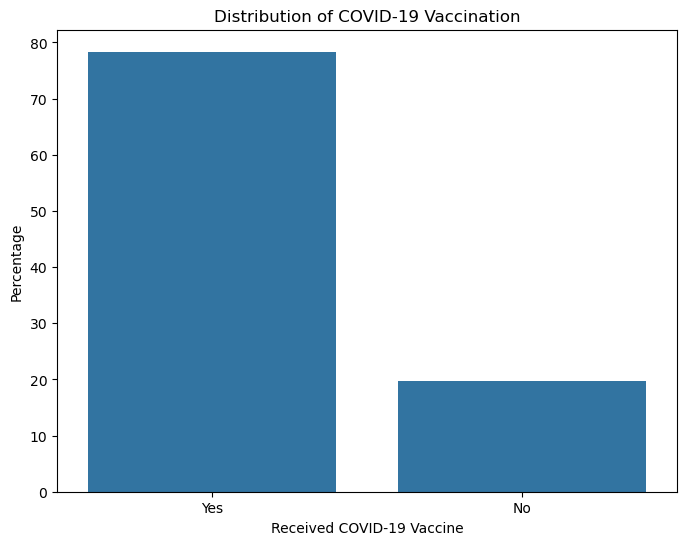

In [29]:
# SHTCVD191_A: COVID-19 vaccination
vax_dist = get_distribution('SHTCVD191_A')
vax_dist['SHTCVD191_A'] = vax_dist['SHTCVD191_A'].map({1: 'Yes', 2: 'No'})
plt.figure(figsize=(8, 6))
sns.barplot(x='SHTCVD191_A', y='percentage', data=vax_dist)
plt.title('Distribution of COVID-19 Vaccination')
plt.xlabel('Received COVID-19 Vaccine')
plt.ylabel('Percentage')
plt.show()

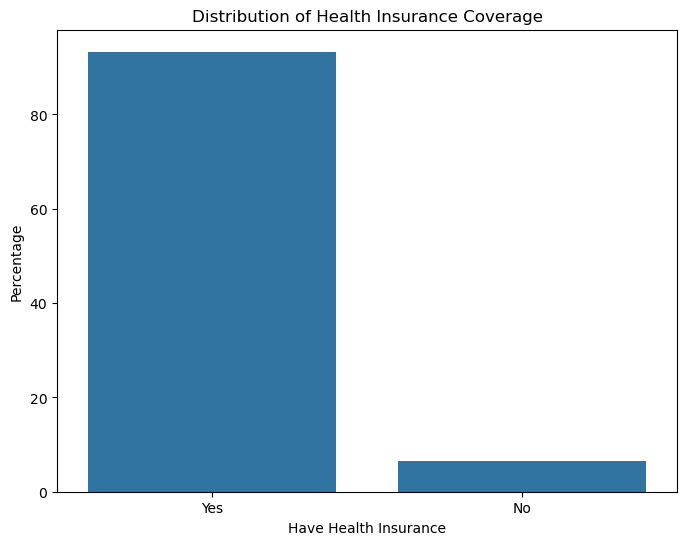

In [30]:
# HICOV_A: Have health insurance
ins_dist = get_distribution('HICOV_A')
ins_dist['HICOV_A'] = ins_dist['HICOV_A'].map({1: 'Yes', 2: 'No'})
plt.figure(figsize=(8, 6))
sns.barplot(x='HICOV_A', y='percentage', data=ins_dist)
plt.title('Distribution of Health Insurance Coverage')
plt.xlabel('Have Health Insurance')
plt.ylabel('Percentage')
plt.show()

[03/30/25 21:24:27] INFO     Using categorical units to plot a list of strings that are all         ]8;id=289736;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=758070;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=506278;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=695966;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

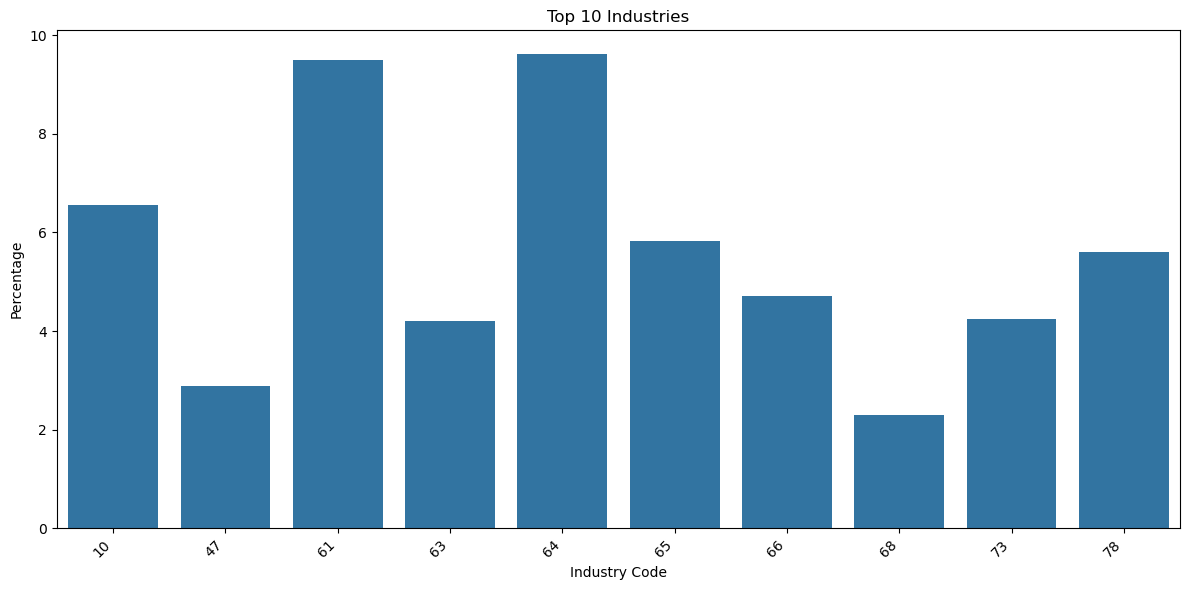

In [31]:
# For EMDINDSTN1_A (industry codes), we might want to show only the top N categories
industry_dist = get_distribution('EMDINDSTN1_A')
top_industries = industry_dist.nlargest(10, 'count')
plt.figure(figsize=(12, 6))
sns.barplot(x='EMDINDSTN1_A', y='percentage', data=top_industries)
plt.title('Top 10 Industries')
plt.xlabel('Industry Code')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

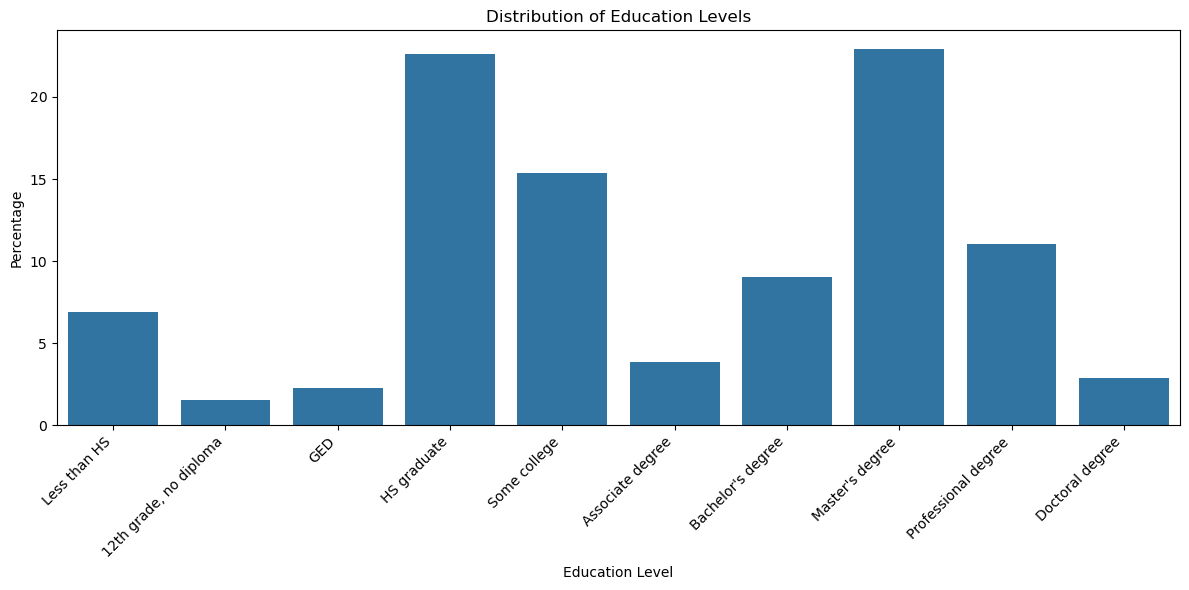

In [32]:
# For EDUCP_A (education level), we might want to label the categories
edu_dist = get_distribution('EDUCP_A')
edu_labels = {
    1: 'Less than HS', 2: '12th grade, no diploma', 3: 'GED', 4: 'HS graduate',
    5: 'Some college', 6: 'Associate degree', 7: "Bachelor's degree", 8: "Master's degree",
    9: 'Professional degree', 10: 'Doctoral degree'
}
edu_dist['EDUCP_A'] = edu_dist['EDUCP_A'].map(edu_labels)
plt.figure(figsize=(12, 6))
sns.barplot(x='EDUCP_A', y='percentage', data=edu_dist)
plt.title('Distribution of Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

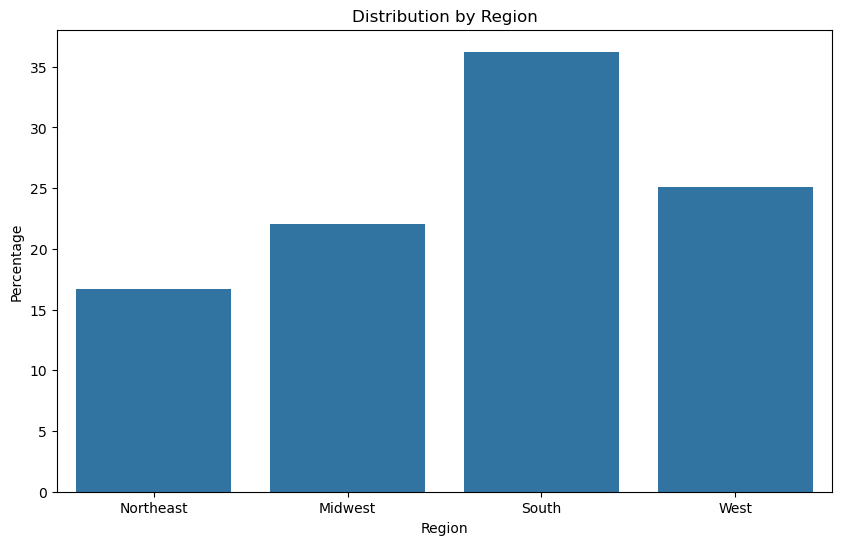

In [33]:
# For REGION, we might want to label the categories
region_dist = get_distribution('REGION')
region_labels = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'}
region_dist['REGION'] = region_dist['REGION'].map(region_labels)
plt.figure(figsize=(10, 6))
sns.barplot(x='REGION', y='percentage', data=region_dist)
plt.title('Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Percentage')
plt.show()

In [24]:
# 5.4 Time Series Analysis
time_series_query = f"""
SELECT 
    SRVY_YR,
    AVG(AGEP_A) as avg_age,
    SUM(CASE WHEN HICOV_A = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*) as percent_insured
FROM {database_name}.{table_name}
GROUP BY SRVY_YR
ORDER BY SRVY_YR
"""

df_time_series = pd.read_sql(time_series_query, conn)
print("Trends Over Time:")
display(df_time_series)

Trends Over Time:


,SRVY_YR,avg_age,percent_insured
0,2019,52.120136,92.680564
1,2020,53.605265,93.601115
2,2021,52.626959,93.216200
3,2022,53.050920,93.280532
4,2023,53.267868,93.767360


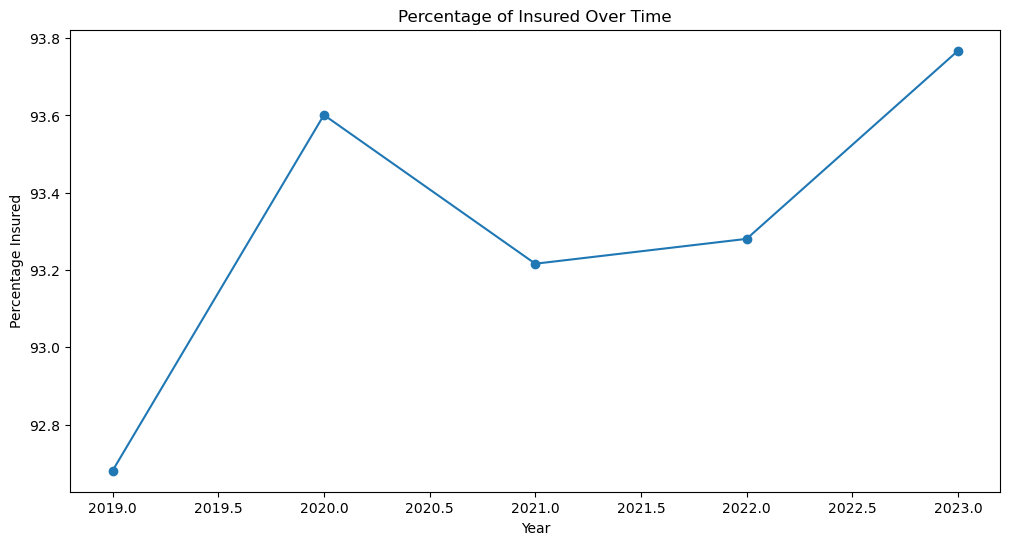

In [25]:
# Visualization for time series
plt.figure(figsize=(12, 6))
plt.plot(df_time_series['SRVY_YR'], df_time_series['percent_insured'], marker='o')
plt.title('Percentage of Insured Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage Insured')
plt.show()

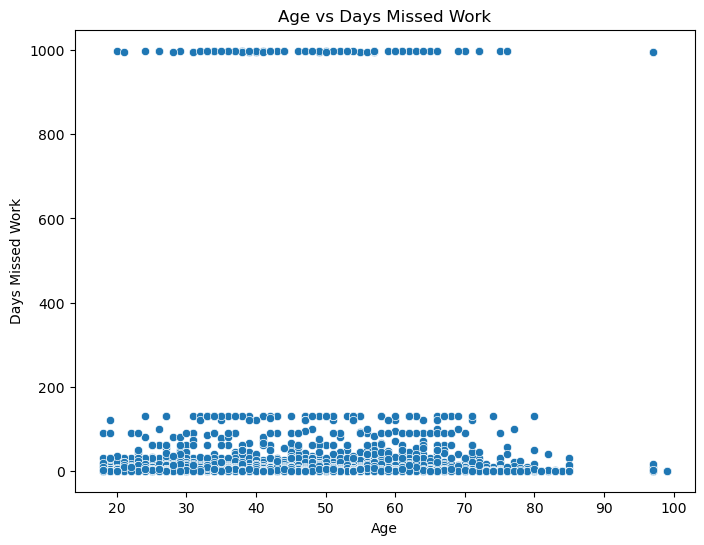

Correlation coefficient: 0.017678029093234175


In [26]:
# 5.5 Correlation Analysis
correlation_query = f"""
SELECT AGEP_A, EMPDYSMSS3_A
FROM {database_name}.{table_name}
WHERE AGEP_A IS NOT NULL AND EMPDYSMSS3_A IS NOT NULL
LIMIT 10000
"""

df_corr = pd.read_sql(correlation_query, conn)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='AGEP_A', y='EMPDYSMSS3_A', data=df_corr)
plt.title('Age vs Days Missed Work')
plt.xlabel('Age')
plt.ylabel('Days Missed Work')
plt.show()
print("Correlation coefficient:", df_corr['AGEP_A'].corr(df_corr['EMPDYSMSS3_A']))

In [27]:
# 5.6 Summary Statistics by Group
group_stats_query = f"""
SELECT 
    REGION,
    AVG(AGEP_A) as avg_age,
    AVG(EMPDYSMSS3_A) as avg_days_missed,
    SUM(CASE WHEN HICOV_A = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*) as percent_insured
FROM {database_name}.{table_name}
GROUP BY REGION
ORDER BY REGION
"""

df_group_stats = pd.read_sql(group_stats_query, conn)
print("Statistics by Region:")
display(df_group_stats)

Statistics by Region:


,REGION,avg_age,avg_days_missed,percent_insured
0,1,53.918039,20.164938,96.215633
1,2,53.310710,12.383864,94.723330
2,3,52.989916,13.578828,90.503306
3,4,51.846180,13.333151,94.167021


[03/30/25 21:02:28] INFO     Using categorical units to plot a list of strings that are all         ]8;id=767615;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=73730;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=129105;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=801063;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

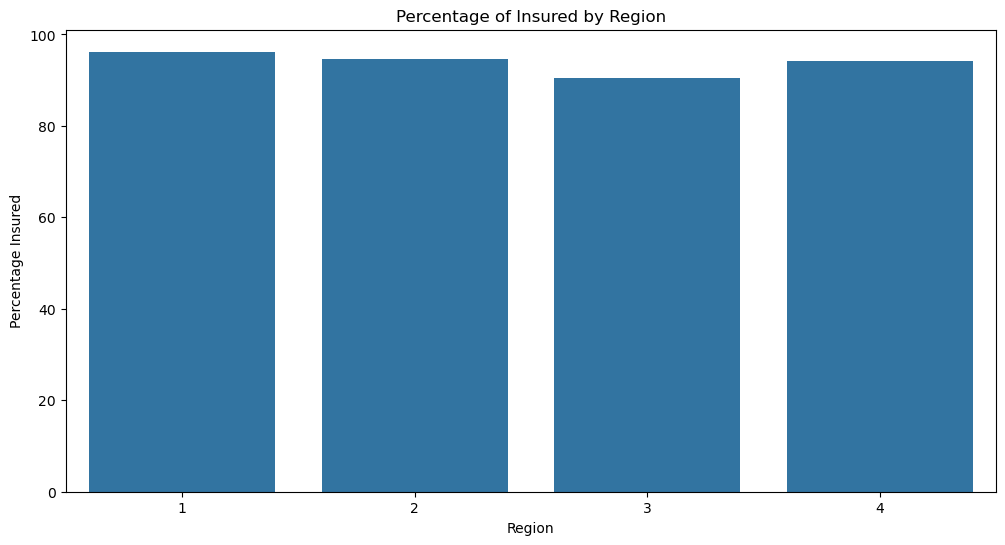

In [28]:
# Visualization for group statistics
plt.figure(figsize=(12, 6))
sns.barplot(x='REGION', y='percent_insured', data=df_group_stats)
plt.title('Percentage of Insured by Region')
plt.xlabel('Region')
plt.ylabel('Percentage Insured')
plt.show()

# SECTION 7: Set Up Supporting Tables - Industry Codes

In [29]:
# Define the S3 bucket and paths
bucket_name = "usd-team1-ads508"
source_key = "industry_code_mapping.csv"
destination_prefix = "industry_code_mapping/"
destination_key = f"{destination_prefix}{source_key}"

In [30]:
# Copy the file to the new directory
s3_client.copy_object(
    Bucket=bucket_name,
    CopySource={'Bucket': bucket_name, 'Key': source_key},
    Key=destination_key
)
print(f"File copied to s3://{bucket_name}/{destination_key}")

File copied to s3://usd-team1-ads508/industry_code_mapping/industry_code_mapping.csv


In [31]:
# Now create the Athena table
database_name = "db_508"
table_name = "industry_code_mapping"
s3_data_path = f"s3://{bucket_name}/{destination_prefix}"

In [32]:
# Drop the table if it exists to recreate it
drop_table_statement = f"DROP TABLE IF EXISTS {database_name}.{table_name}"
pd.read_sql(drop_table_statement, conn)

""


In [33]:
# Create the table - Change industry_year_code to BIGINT to match Industry_code in industry_year_avg
create_table_statement = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name} (
    EMDINDSTN1_A INT,
    industry_year_code BIGINT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LINES TERMINATED BY '\\n'
LOCATION '{s3_data_path}'
TBLPROPERTIES ('skip.header.line.count'='1')
"""

# Print the create table statement (with sensitive information redacted)
print_statement = create_table_statement.replace(s3_data_path, "s3://[REDACTED_BUCKET]/industry_code_mapping/")
print("Create Table Statement:")
print(print_statement)

Create Table Statement:

CREATE EXTERNAL TABLE IF NOT EXISTS db_508.industry_code_mapping (
    EMDINDSTN1_A INT,
    industry_year_code BIGINT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LINES TERMINATED BY '\n'
LOCATION 's3://[REDACTED_BUCKET]/industry_code_mapping/'
TBLPROPERTIES ('skip.header.line.count'='1')



In [34]:
# Execute the create table statement
pd.read_sql(create_table_statement, conn)

# Verify table creation
show_tables_statement = f"SHOW TABLES in {database_name}"
df_show = pd.read_sql(show_tables_statement, conn)
print("\nTables in the database:")
print(df_show)


Tables in the database:
                      tab_name
0       county_health_rankings
1        industry_code_mapping
2            industry_year_avg
3                 nhis_dataset
4  nhis_dataset_with_estimates


In [35]:
# Check if the table was created successfully
table_created = table_name in df_show['tab_name'].values
print(f"\nTable '{table_name}' creation successful: {table_created}")


Table 'industry_code_mapping' creation successful: True


In [36]:
# If the table was created successfully, show a sample of the data
if table_created:
    sample_query = f"""
    SELECT *
    FROM {database_name}.{table_name}
    LIMIT 10
    """
    print("\nSample data from the table:")
    df_sample = pd.read_sql(sample_query, conn)
    display(df_sample)


Sample data from the table:


,emdindstn1_a,industry_year_code
0,0,0
1,1,110000
2,2,110000
3,3,110000
4,4,110000
5,5,110000
6,6,210000
7,7,210000
8,8,210000
9,9,220000


# SECTION 8: Industry Year Average Table

In [37]:
# Define the S3 bucket and paths
bucket_name = "usd-team1-ads508"
source_key = "industry_year_avg.csv"
destination_prefix = "industry_year_avg/"
destination_key = f"{destination_prefix}{source_key}"

In [38]:
# Copy the file to the new directory
s3_client.copy_object(
    Bucket=bucket_name,
    CopySource={'Bucket': bucket_name, 'Key': source_key},
    Key=destination_key
)
print(f"File copied to s3://{bucket_name}/{destination_key}")

File copied to s3://usd-team1-ads508/industry_year_avg/industry_year_avg.csv


In [39]:
# Now create the Athena table
database_name = "db_508"
table_name = "industry_year_avg"
s3_data_path = f"s3://{bucket_name}/{destination_prefix}"

In [40]:
# Drop the table if it exists to recreate it
drop_table_statement = f"DROP TABLE IF EXISTS {database_name}.{table_name}"
pd.read_sql(drop_table_statement, conn)

""


In [41]:
# Create the table - Note that Industry_code is BIGINT, which must match industry_year_code in the mapping table
create_table_statement = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name} (
    Year INT,
    Industry STRING,
    Industry_code BIGINT,
    Avg_Estimate DOUBLE
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LINES TERMINATED BY '\\n'
LOCATION '{s3_data_path}'
TBLPROPERTIES ('skip.header.line.count'='1')
"""

# Print the create table statement (with sensitive information redacted)
print_statement = create_table_statement.replace(s3_data_path, "s3://[REDACTED_BUCKET]/industry_year_avg/")
print("Create Table Statement:")
print(print_statement)

Create Table Statement:

CREATE EXTERNAL TABLE IF NOT EXISTS db_508.industry_year_avg (
    Year INT,
    Industry STRING,
    Industry_code BIGINT,
    Avg_Estimate DOUBLE
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LINES TERMINATED BY '\n'
LOCATION 's3://[REDACTED_BUCKET]/industry_year_avg/'
TBLPROPERTIES ('skip.header.line.count'='1')



In [42]:
# Execute the create table statement
pd.read_sql(create_table_statement, conn)

# Verify table creation
show_tables_statement = f"SHOW TABLES in {database_name}"
df_show = pd.read_sql(show_tables_statement, conn)
print("\nTables in the database:")
print(df_show)

# Check if the table was created successfully
table_created = table_name in df_show['tab_name'].values
print(f"\nTable '{table_name}' creation successful: {table_created}")


Tables in the database:
                      tab_name
0       county_health_rankings
1        industry_code_mapping
2            industry_year_avg
3                 nhis_dataset
4  nhis_dataset_with_estimates

Table 'industry_year_avg' creation successful: True


In [43]:
# If the table was created successfully, show a sample of the data
if table_created:
    sample_query = f"""
    SELECT *
    FROM {database_name}.{table_name}
    WHERE year = 2022
    LIMIT 10
    """
    print("\nSample data from the table:")
    df_sample = pd.read_sql(sample_query, conn)
    display(df_sample)


Sample data from the table:


,year,industry,industry_code,avg_estimate
0,2022,Accommodation and food services,720000.0,35.615385
1,2022,Administrative and support and waste managemen...,560000.0,65.000000
2,2022,All industries,0.0,56.784519
3,2022,Construction,230000.0,42.250000
4,2022,Credit intermediation,522000.0,34.307692
5,2022,Education and health services,600000.0,62.694444
6,2022,Educational services,610000.0,68.151515
7,2022,Elementary and secondary schools,611100.0,77.571429
8,2022,Finance and insurance,520000.0,40.923077
9,2022,Financial activities,NaN,33.230769


# SECTION 9: Create County Health Rankings Table

In [44]:
# Define the S3 bucket and paths
bucket_name = "usd-team1-ads508"
source_key = "county_health_rankings.csv"
destination_prefix = "county_health_rankings/"
destination_key = f"{destination_prefix}{source_key}"

In [45]:
# Copy the file to a dedicated directory
s3_client.copy_object(
    Bucket=bucket_name,
    CopySource={'Bucket': bucket_name, 'Key': source_key},
    Key=destination_key
)
print(f"File copied to s3://{bucket_name}/{destination_key}")

File copied to s3://usd-team1-ads508/county_health_rankings/county_health_rankings.csv


In [46]:
# Now create the Athena table
database_name = "db_508"
table_name = "county_health_rankings"
s3_data_path = f"s3://{bucket_name}/{destination_prefix}"

In [47]:
# Drop the table if it exists to recreate it
drop_table_statement = f"DROP TABLE IF EXISTS {database_name}.{table_name}"
pd.read_sql(drop_table_statement, conn)

""


In [48]:
# Create the table with the provided schema
create_table_statement = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name} (
    year INT,
    state STRING,
    county STRING,
    premature_death DOUBLE,
    poor_fair_health DOUBLE,
    adult_smoking DOUBLE,
    obesity_rate DOUBLE,
    physical_inactivity DOUBLE,
    access_exercise DOUBLE,
    flu_vaccination_rate DOUBLE,
    mammography_screening DOUBLE,
    uninsured_rate DOUBLE,
    driving_alone_to_work DOUBLE,
    long_commute DOUBLE,
    severe_housing_problems DOUBLE,
    air_pollution_pmatter DOUBLE,
    drinking_water_violations DOUBLE,
    children_in_poverty DOUBLE,
    income_inequality DOUBLE,
    social_associations DOUBLE,
    homeownership DOUBLE,
    median_household_income DOUBLE,
    population INT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LINES TERMINATED BY '\\n'
LOCATION '{s3_data_path}'
TBLPROPERTIES ('skip.header.line.count'='1')
"""

In [49]:
# Print the create table statement (with sensitive information redacted)
print_statement = create_table_statement.replace(s3_data_path, "s3://[REDACTED_BUCKET]/county_health_rankings/")
print("Create Table Statement:")
print(print_statement)

Create Table Statement:

CREATE EXTERNAL TABLE IF NOT EXISTS db_508.county_health_rankings (
    year INT,
    state STRING,
    county STRING,
    premature_death DOUBLE,
    poor_fair_health DOUBLE,
    adult_smoking DOUBLE,
    obesity_rate DOUBLE,
    physical_inactivity DOUBLE,
    access_exercise DOUBLE,
    flu_vaccination_rate DOUBLE,
    mammography_screening DOUBLE,
    uninsured_rate DOUBLE,
    driving_alone_to_work DOUBLE,
    long_commute DOUBLE,
    severe_housing_problems DOUBLE,
    air_pollution_pmatter DOUBLE,
    drinking_water_violations DOUBLE,
    children_in_poverty DOUBLE,
    income_inequality DOUBLE,
    social_associations DOUBLE,
    homeownership DOUBLE,
    median_household_income DOUBLE,
    population INT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LINES TERMINATED BY '\n'
LOCATION 's3://[REDACTED_BUCKET]/county_health_rankings/'
TBLPROPERTIES ('skip.header.line.count'='1')



In [50]:
# Execute the create table statement
pd.read_sql(create_table_statement, conn)

# Verify table creation
show_tables_statement = f"SHOW TABLES in {database_name}"
df_show = pd.read_sql(show_tables_statement, conn)
print("\nTables in the database:")
print(df_show)

# Check if the table was created successfully
table_created = table_name in df_show['tab_name'].values
print(f"\nTable '{table_name}' creation successful: {table_created}")


Tables in the database:
                      tab_name
0       county_health_rankings
1        industry_code_mapping
2            industry_year_avg
3                 nhis_dataset
4  nhis_dataset_with_estimates

Table 'county_health_rankings' creation successful: True


In [51]:
# If the table was created successfully, show a sample of the data
if table_created:
    sample_query = f"""
    SELECT *
    FROM {database_name}.{table_name}
    LIMIT 10
    """
    print("\nSample data from the table:")
    df_sample = pd.read_sql(sample_query, conn)
    display(df_sample)

# Count records in the table
count_query = f"""
SELECT COUNT(*) as total_records 
FROM {database_name}.{table_name}
"""
df_count = pd.read_sql(count_query, conn)
print(f"\nTotal records in {table_name}: {df_count['total_records'].iloc[0]}")

# Get basic stats about the data
stats_query = f"""
SELECT 
    year,
    COUNT(*) as county_count,
    AVG(uninsured_rate) as avg_uninsured_rate,
    AVG(obesity_rate) as avg_obesity_rate,
    AVG(flu_vaccination_rate) as avg_flu_vaccination_rate,
    SUM(population) as total_population
FROM {database_name}.{table_name}
GROUP BY year
ORDER BY year
"""
df_stats = pd.read_sql(stats_query, conn)
print("\nBasic statistics by year:")
display(df_stats)


Sample data from the table:


,year,state,county,premature_death,poor_fair_health,adult_smoking,obesity_rate,physical_inactivity,access_exercise,flu_vaccination_rate,...,long_commute,severe_housing_problems,air_pollution_pmatter,drinking_water_violations,children_in_poverty,income_inequality,social_associations,homeownership,median_household_income,population
0,2019,US,United States,6900.630354,0.184043,0.193747,0.285,0.222,0.838945,0.426497,...,0.352,0.183731,8.237422,0.365979,0.184,4.941486,9.300353,0.638187,60336.0,325719178
1,2019,AL,Alabama,9917.232898,0.214024,0.215382,0.351,0.282,0.616496,0.420000,...,0.337,0.149122,11.000000,0.074627,0.244,5.238579,12.242716,0.685744,48193.0,4874747
2,2019,AL,Autauga County,8824.057123,0.184111,0.191247,0.375,0.311,0.686775,0.410000,...,0.383,0.149546,11.700000,0.000000,0.193,4.636664,12.631731,0.732877,58343.0,55504
3,2019,AL,Baldwin County,7224.632160,0.180605,0.167955,0.310,0.238,0.719710,0.450000,...,0.405,0.138317,10.300000,1.000000,0.147,4.518560,10.692213,0.728593,56607.0,212628
4,2019,AL,Barbour County,9586.165037,0.257734,0.215409,0.443,0.282,0.536257,0.370000,...,0.338,0.154555,11.500000,0.000000,0.503,5.755063,8.472944,0.625068,32490.0,25270
5,2019,AL,Bibb County,11783.543675,0.199969,0.199164,0.378,0.349,0.162514,0.390000,...,0.486,0.109609,11.200000,0.000000,0.273,4.254594,10.157665,0.753615,45795.0,22668
6,2019,AL,Blount County,10908.101822,0.210953,0.196522,0.344,0.285,0.229493,0.380000,...,0.597,0.104012,11.700000,0.000000,0.185,4.126883,9.011507,0.785210,48253.0,58013
7,2019,AL,Bullock County,12066.910263,0.294077,0.234783,0.394,0.292,0.266905,0.260000,...,0.473,0.207598,11.200000,0.000000,0.483,6.599523,9.650647,0.700272,29113.0,10309
8,2019,AL,Butler County,14018.606262,0.265026,0.221977,0.402,0.347,0.485797,0.350000,...,0.318,0.137803,10.600000,0.000000,0.330,5.122786,11.501150,0.700709,36842.0,19825
9,2019,AL,Calhoun County,12217.759984,0.195847,0.204622,0.371,0.302,0.447138,0.380000,...,0.306,0.145388,11.800000,0.000000,0.242,4.983814,14.309272,0.693918,45937.0,114728



Total records in county_health_rankings: 15970

Basic statistics by year:


,year,county_count,avg_uninsured_rate,avg_obesity_rate,avg_flu_vaccination_rate,total_population
0,2019,3194,0.111080,0.320273,0.405570,977157534
1,2020,3194,0.114449,0.328081,0.418161,981502302
2,2021,3194,0.114679,0.334022,0.431489,984718569
3,2022,3194,0.119115,0.356662,0.430004,988452369
4,2023,3194,0.118120,0.361415,0.447263,995681235


# SECTION 10: Create NHIS Dataset with Industry Average Estimates

In [52]:
# Define the new table name for our enhanced dataset
new_table_name = "nhis_dataset_with_estimates"

In [53]:
# Drop the table if it exists to recreate it
drop_table_statement = f"DROP TABLE IF EXISTS {database_name}.{new_table_name}"
pd.read_sql(drop_table_statement, conn)

""


In [54]:
# Create a location for the new table - with a timestamp to ensure uniqueness
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
s3_new_table_path = f"s3://{bucket}/nhis_with_estimates_{timestamp}"

In [55]:
# Clean up the existing S3 directory (since we can't overwrite it)
print(f"Removing existing S3 path if it exists...")
!aws s3 rm --recursive s3://{bucket}/nhis_with_estimates > /dev/null 2>&1

Removing existing S3 path if it exists...


In [56]:
# Define the CREATE TABLE AS SELECT (CTAS) query
create_table_query = f"""
CREATE TABLE {database_name}.{new_table_name}
WITH (
    format = 'PARQUET',
    external_location = '{s3_new_table_path}',
    partitioned_by = ARRAY['SRVY_YR']
) AS
SELECT 
    n.EVERCOVD_A,
    n.SHTCVD191_A,
    n.EMPDYSMSS3_A,
    n.HICOV_A,
    n.EMDINDSTN1_A,
    n.SEX_A,
    n.AGEP_A,
    n.EDUCP_A,
    n.REGION,
    i.Avg_Estimate,
    n.SRVY_YR  -- Partition column must be the last column
FROM 
    {database_name}.nhis_dataset n
LEFT JOIN 
    {database_name}.industry_code_mapping m ON n.EMDINDSTN1_A = m.EMDINDSTN1_A
LEFT JOIN 
    {database_name}.industry_year_avg i ON 
        m.industry_year_code = i.Industry_code AND 
        n.SRVY_YR = i.Year
"""

# Print query with redacted path for security
print_query = create_table_query.replace(s3_new_table_path, "s3://[REDACTED_BUCKET]/nhis_with_estimates_[TIMESTAMP]")
print("Creating new table with industry average estimates:")
print(print_query)

Creating new table with industry average estimates:

CREATE TABLE db_508.nhis_dataset_with_estimates
WITH (
    format = 'PARQUET',
    external_location = 's3://[REDACTED_BUCKET]/nhis_with_estimates_[TIMESTAMP]',
    partitioned_by = ARRAY['SRVY_YR']
) AS
SELECT 
    n.EVERCOVD_A,
    n.SHTCVD191_A,
    n.EMPDYSMSS3_A,
    n.HICOV_A,
    n.EMDINDSTN1_A,
    n.SEX_A,
    n.AGEP_A,
    n.EDUCP_A,
    n.REGION,
    i.Avg_Estimate,
    n.SRVY_YR  -- Partition column must be the last column
FROM 
    db_508.nhis_dataset n
LEFT JOIN 
    db_508.industry_code_mapping m ON n.EMDINDSTN1_A = m.EMDINDSTN1_A
LEFT JOIN 
    db_508.industry_year_avg i ON 
        m.industry_year_code = i.Industry_code AND 
        n.SRVY_YR = i.Year



In [57]:
# Execute the query to create the new table with proper error handling
table_creation_success = False
try:
    pd.read_sql(create_table_query, conn)
    print("New table created successfully!")
    table_creation_success = True
except Exception as e:
    print(f"Error creating table: {e}")
    print("Attempting to diagnose the issue...")
    
    # Check if the target location exists
    !aws s3 ls {s3_new_table_path} || echo "Target location does not exist (good)"
    
    # List S3 errors if any
    !aws s3 ls s3://{bucket}/athena/staging/tables/ | tail -5

New table created successfully!


In [58]:
# Verify the table was created
show_tables_statement = f"SHOW TABLES in {database_name}"
df_show = pd.read_sql(show_tables_statement, conn)
print("\nTables in the database:")
print(df_show)

# Check if the new table exists
new_table_created = new_table_name in df_show['tab_name'].values
print(f"\nTable '{new_table_name}' creation successful: {new_table_created}")


Tables in the database:
                      tab_name
0       county_health_rankings
1        industry_code_mapping
2            industry_year_avg
3                 nhis_dataset
4  nhis_dataset_with_estimates

Table 'nhis_dataset_with_estimates' creation successful: True


In [59]:
# Check record count
count_query = f"SELECT COUNT(*) as total_records FROM {database_name}.{new_table_name}"
df_count = pd.read_sql(count_query, conn)
print(f"\nTotal records in {new_table_name}: {df_count['total_records'].iloc[0]}")


Total records in nhis_dataset_with_estimates: 150220


In [60]:
# Show a sample of records with industry averages
sample_query = f"""
SELECT *
FROM {database_name}.{new_table_name}
WHERE Avg_Estimate IS NOT NULL
LIMIT 10
"""
print("\nSample data with industry averages:")
df_sample = pd.read_sql(sample_query, conn)
display(df_sample)


Sample data with industry averages:


,evercovd_a,shtcvd191_a,empdysmss3_a,hicov_a,emdindstn1_a,sex_a,agep_a,educp_a,region,avg_estimate,srvy_yr
0,2,1,0,1,78,1,48,5,3,65.818182,2023
1,1,1,0,1,64,2,42,9,3,69.656250,2023
2,2,1,40,1,64,2,50,7,3,69.656250,2023
3,2,1,2,1,66,2,46,8,3,83.000000,2023
4,1,2,4,1,64,2,36,8,3,69.656250,2023
5,1,1,3,1,40,1,44,10,3,30.538462,2023
6,2,1,5,1,39,1,61,1,3,30.538462,2023
7,1,2,0,2,10,2,35,8,3,25.285714,2023
8,2,1,1,1,40,1,56,8,3,30.538462,2023
9,2,1,3,1,29,1,49,4,3,27.692308,2023


In [61]:
# Compare the count of records with and without estimates
stats_query = f"""
SELECT 
    COUNT(*) as total_records,
    COUNT(Avg_Estimate) as records_with_estimates,
    COUNT(*) - COUNT(Avg_Estimate) as records_without_estimates,
    (COUNT(Avg_Estimate) * 100.0 / COUNT(*)) as percent_with_estimates
FROM {database_name}.{new_table_name}
"""
df_stats = pd.read_sql(stats_query, conn)
print("\nStatistics on industry average estimates:")
display(df_stats)


Statistics on industry average estimates:


,total_records,records_with_estimates,records_without_estimates,percent_with_estimates
0,150220,49118,101102,32.697377


In [62]:
# Additional analysis by year
year_stats_query = f"""
SELECT 
    SRVY_YR as year,
    COUNT(*) as total_records,
    COUNT(Avg_Estimate) as records_with_estimates,
    (COUNT(Avg_Estimate) * 100.0 / COUNT(*)) as percent_with_estimates
FROM {database_name}.{new_table_name}
GROUP BY SRVY_YR
ORDER BY SRVY_YR
"""
df_year_stats = pd.read_sql(year_stats_query, conn)
print("\nEstimate coverage by year:")
display(df_year_stats)


Estimate coverage by year:


,year,total_records,records_with_estimates,percent_with_estimates
0,2019,31997,0,0.000000
1,2020,31568,17356,54.979726
2,2021,29482,16016,54.324673
3,2022,27651,0,0.000000
4,2023,29522,15746,53.336495


In [ ]:
# Stop cell execution here
sys.exit("Stopping execution here. Cells below will not run.")

In [63]:
# Export table data to CSV and save to S3 bucket
export_query = f"""
SELECT *
FROM {database_name}.{new_table_name}
LIMIT 1000000
"""

# Execute the query and load data into a pandas DataFrame
export_df = pd.read_sql(export_query, conn)
print(f"Loaded {len(export_df)} rows of data")

Loaded 150220 rows of data


In [64]:
# Define the CSV file path in S3 with a fixed name
csv_filename = "nhis_dataset_with_estimates.csv"
csv_s3_path = f"s3://{bucket}/{csv_filename}"

In [65]:
# Convert to CSV and upload
csv_buffer = io.StringIO()
export_df.to_csv(csv_buffer, index=False)
s3_client.put_object(
    Bucket=bucket,
    Key=csv_filename,
    Body=csv_buffer.getvalue()
)

print(f"CSV file successfully saved to {csv_s3_path}")

CSV file successfully saved to s3://usd-team1-ads508/nhis_dataset_with_estimates.csv


In [66]:
# Show the S3 file details
!aws s3 ls s3://{bucket}/{csv_filename}

2025-03-30 21:03:37    4808201 nhis_dataset_with_estimates.csv
